# Imports

In [62]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

# Load Data

In [2]:
conn = sqlite3.connect("../data/db/NBA-L2M.db")
c = conn.cursor()

reports = pd.read_sql("SELECT * FROM reports", conn, parse_dates=['date'])
reports.head(2)

,report,away,home,date,season,away_score,home_score,winner
0,L2M-DEN-MIN-11-03-16,DEN,MIN,2016-11-03,2016-17 NBA Regular Season,102.0,99.0,DEN
1,L2M-SAC-CHI-01-21-17,SAC,CHI,2017-01-21,2016-17 NBA Regular Season,99.0,102.0,CHI


In [3]:
calls = pd.read_sql("SELECT * FROM calls", conn).replace(
    {"decision":{"CC*": "CC", "CNC*":"CNC", "IC*": "IC", "INC*": "INC"}})
calls.head(2)

,report,period,time,call,committing,disadvantaged,decision,committing_team,disadvantaged_team
0,L2M-DEN-MIN-11-03-16,Q4,,Foul: Shooting,Karl-Anthony Towns,Emmanuel Mudiay,CC,MIN,DEN
1,L2M-DEN-MIN-11-03-16,Q4,,Foul: Offensive,Karl-Anthony Towns,Danilo Gallinari,CNC,MIN,DEN


# Aggregate Stats. How Many Blown Calls per Game?

In [97]:
df = pd.merge(reports, calls, on='report', how='left')
call_types = df.groupby(['report', 'date', 'decision']).size().unstack(level=-1).fillna(0)
call_types['Total'] = call_types.sum(axis=1)
call_types.columns = ['Incidental', 'CC', 'CNC', 'IC', 'INC', 'Total']
print len(call_types)
print call_types.describe(include='all')
call_types.head(2)

962
       Incidental          CC         CNC          IC         INC       Total
count  962.000000  962.000000  962.000000  962.000000  962.000000  962.000000
mean     0.927235    5.247401    8.486486    0.177755    1.403326   16.242204
std      1.302725    3.212735    5.319386    0.431106    1.499049    8.347211
min      0.000000    0.000000    0.000000    0.000000    0.000000    3.000000
25%      0.000000    3.000000    5.000000    0.000000    0.000000   11.000000
50%      0.500000    5.000000    7.000000    0.000000    1.000000   14.000000
75%      1.000000    7.000000   11.000000    0.000000    2.000000   19.000000
max     10.000000   27.000000   39.000000    3.000000   14.000000   76.000000


,,Incidental,CC,CNC,IC,INC,Total
report,date,,,,,,
L2M-ATL-BKN-04-08-15,2015-04-08,0.0,5.0,2.0,0.0,0.0,7.0
L2M-ATL-BKN-04-27-15,2015-04-27,0.0,6.0,12.0,0.0,4.0,22.0


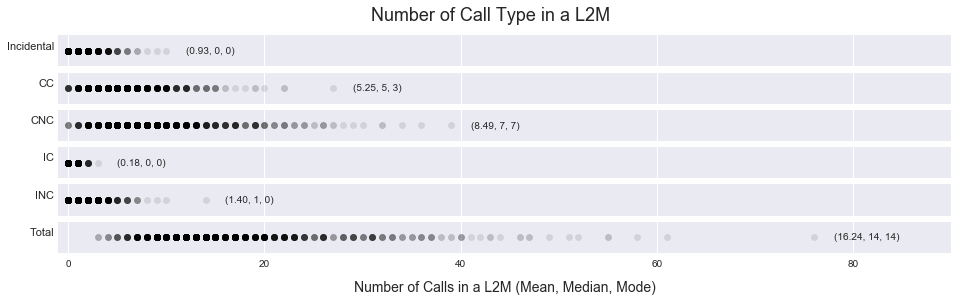

In [99]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=6, ncols=1, figsize=(16,4))

for col, ax in zip(call_types.columns, [ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.scatter(call_types[col], np.zeros(len(call_types)), s=40, alpha=0.1, c='k')
    ax.set_xlim(-1,90)
    ax.set_yticks([])
    ax.set_ylabel(col, rotation=0, ha='right')
    ax.text(call_types[col].max() + 2, 0,
            "({0:.2f}, {1:.0f}, {2:.0f})".format(
            call_types[col].mean(), call_types[col].median(),
            call_types[col].mode()[0]), va='center')
    if ax != ax6:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Number of Calls in a L2M (Mean, Median, Mode)", fontsize=14, labelpad=12)
    fig.suptitle("Number of Call Type in a L2M", fontsize=18)

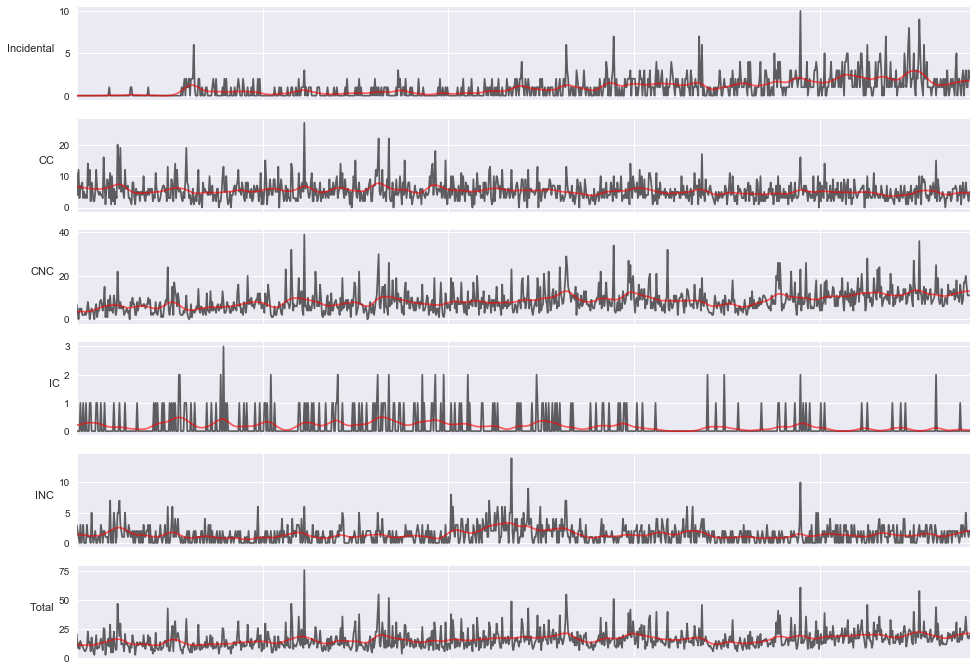

In [100]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=6, ncols=1, figsize=(16,12))

for col, ax in zip(call_types.columns, [ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.set_ylabel(col, rotation=0, ha='right')
    call_types.sort_index(level=1)[col].plot(ax=ax, color='k', alpha=0.6)
    gf_data = gaussian_filter(call_types.sort_index(level=1)[col].values, 7)
    ax.plot(range(len(gf_data)), gf_data, c='r', alpha=0.6)
#     ax.set_xticklabels(map(lambda x: x[1], call_types.sort_index(level=1).index))
    ax.set_xticklabels([])
    ax.set_xlabel('')

# Blown Calls By Team

In [6]:
def blown_calls_rate(season):
    report_years = reports[reports.season.isin(season)]
    blown_calls = calls[(calls.decision == "IC") &  (calls.disadvantaged_team != "NaN")| 
                        (calls.decision == "INC") &  (calls.disadvantaged_team != "NaN")|
                        (calls.decision == "IC*") &  (calls.disadvantaged_team != "NaN")|
                        (calls.decision == "INC*") &  (calls.disadvantaged_team != "NaN")]
    
    df = pd.merge(report_years, blown_calls, on='report', how='left')
    
    br = pd.merge(pd.DataFrame(df.groupby("disadvantaged_team").size(), columns=["BlownCalls"]),
                  pd.merge(pd.DataFrame(report_years.groupby("away").size(), columns=["away"],),
                           pd.DataFrame(report_years.groupby("home").size(), columns=["home"]),
                           left_index=True, right_index=True), how='right', left_index=True, right_index=True)
    
    br['L2Ms'] = br.away + br.home 
    br['BlownRate'] = 1. * br.BlownCalls / br.L2Ms
    return br.sort_values("BlownRate", ascending=False) 

bcr_17 = blown_calls_rate(['2016-17 NBA Regular Season', '2016-17 NBA Playoffs'])
bcr_16 = blown_calls_rate(['2015-16 NBA Regular Season', '2015-16 NBA Playoffs'])
bcr_15 = blown_calls_rate(['2014-15 NBA Regular Season', '2014-15 NBA Playoffs'])
bcr_pl = blown_calls_rate(['2016-17 NBA Playoffs', '2015-16 NBA Playoffs', '2014-15 NBA Playoffs'])
bcr_rs = blown_calls_rate(['2016-17 NBA Regular Season', '2015-16 NBA Regular Season', '2014-15 NBA Regular Season'])
bcr_all = blown_calls_rate(reports.season.unique())

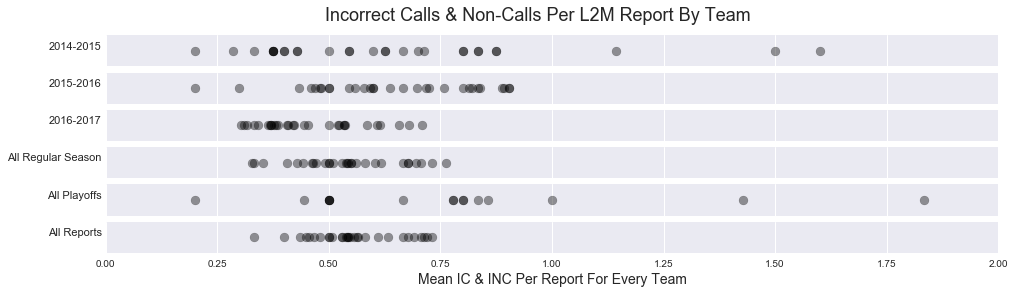

In [7]:
dfs = [bcr_15, bcr_16, bcr_17, bcr_rs, bcr_pl, bcr_all]
names =['2014-2015', '2015-2016', '2016-2017', 'All Regular Season', 'All Playoffs', 'All Reports']

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=6, ncols=1, figsize=(16,4))

for (df, name), ax in zip(zip(dfs, names), [ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.scatter(df.BlownRate, np.zeros(len(df)), s=80, alpha=0.4, c='k')
    ax.set_xlim(0,2)
    ax.set_yticks([])
    ax.set_ylabel(name, rotation=0, ha='right')
    if ax != ax6:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Mean IC & INC Per Report For Every Team", fontsize=14)
    fig.suptitle("Incorrect Calls & Non-Calls Per L2M Report By Team", fontsize=18)

KstestResult(statistic=0.57925970943910299, pvalue=9.2194007983437132e-10)
KstestResult(statistic=0.60094702070665829, pvalue=6.7961636318614183e-11)
KstestResult(statistic=0.61956854389314231, pvalue=1.248112724283601e-11)
KstestResult(statistic=0.62859142388829925, pvalue=5.3297366520155265e-12)
KstestResult(statistic=0.6091393567181147, pvalue=3.1525516841490742e-06)
KstestResult(statistic=0.63055865981823633, pvalue=4.4153569689342476e-12)


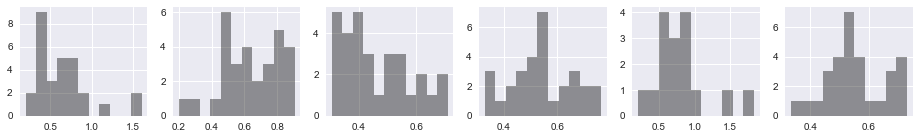

In [8]:
bin_ = 11
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=1, ncols=6, figsize=(16, 2))
for df, ax in zip(dfs, [ax1, ax2, ax3, ax4, ax5, ax6]):
    print kstest(df.BlownRate, 'norm')
    df.BlownRate.hist(bins=bin_, ax=ax, alpha=0.4, color='k')

# Home and Away Variations?

In [115]:
# Do the refs swallow the whistle for away teams?
df = df[df.disadvantaged_team != 'NaN']
df['disadvantaged_away'] = df.away == df.disadvantaged_team
df.groupby(['decision', 'disadvantaged_away']).size()

decision  disadvantaged_away
          False                   93
          True                    91
CC        False                 1992
          True                  1866
CNC       False                 3872
          True                  3967
IC        False                   79
          True                    66
INC       False                  452
          True                   476
dtype: int64

# Do Blown Calls Matter?

In [160]:
# Do blown calls result in losses?
df = pd.merge(reports, calls, on='report', how='left')
df = df[(df.disadvantaged_team != 'NaN') & (df.decision == "INC")|
        (df.disadvantaged_team != 'NaN') & (df.decision == "IC")]
df['disadvantaged_lose'] = df.disadvantaged_team != df.winner
blown_calls_matter = df.groupby(['report', 'disadvantaged_lose']).size().unstack(level=1).fillna(0)
blown_calls_matter.columns = ['False', 'True']
blown_calls_matter['more_disadvantaged_lost'] = blown_calls_matter['True'] > blown_calls_matter['False']
blown_calls_matter['more_disavantaged_won'] = blown_calls_matter['True'] < blown_calls_matter['False']
blown_calls_matter['teams_were_equally_disadvantaged'] = blown_calls_matter['True'] == blown_calls_matter['False']
blown_calls_matter.groupby(['more_disadvantaged_lost', 'teams_were_equally_disadvantaged']).size()

more_disadvantaged_lost  teams_were_equally_disadvantaged
False                    False                               275
                         True                                108
True                     False                               218
dtype: int64